<a href="https://colab.research.google.com/github/joaopamaral/tcc_puc_cdbd/blob/master/StateFarm_DistractedDriver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil, pathlib, glob, sys

IN_COLAB = 'google.colab' in sys.modules

%matplotlib inline
plt.style.use('ggplot')

In [2]:
import tensorflow as tf

tf.__version__

'2.2.0-rc2'

In [3]:
gdrive_kaggle_dir = '/gdrive/My Drive/Kaggle'
competition_name = 'state-farm-distracted-driver-detection'
api_gdrive_credential_location = f'{gdrive_kaggle_dir}/kaggle.json'
data_gdrive_dir = f'{gdrive_kaggle_dir}/{competition_name}'
api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')

In [4]:
# Montando google drive caso esteja executando no google colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

In [5]:
def get_kaggle_json(api_location):
    api_local_credential_location = os.path.join(os.path.expanduser('~'), '.kaggle/kaggle.json')
    if not os.path.exists(api_local_credential_location):
        !mkdir -p ~/.kaggle
        !cp '{api_location}' '{api_local_credential_location}'

def get_kaggle_data_competition(competition_name, gdrive_kaggle_dir=None):
    IN_COLAB = 'google.colab' in sys.modules

    if IN_COLAB and not os.path.exists(competition_name):
        gdrive_competition_path = os.path.join(gdrive_kaggle_dir, competition_name)
        if os.path.exists(gdrive_competition_path):
            !cp -r '{gdrive_competition_path}' .

    if not os.path.exists(competition_name):
        # Instalação do pacote para acesso a API do Kaggle
        !pip -q install kaggle --upgrade
        # Download dos dados da competição
        !kaggle competitions download -c {competition_name} -p {competition_name}
        if IN_COLAB and os.path.exists(gdrive_kaggle_dir):
            !cp -r {competition_name} '{gdrive_kaggle_dir}'

In [6]:
get_kaggle_json(api_gdrive_credential_location)
get_kaggle_data_competition(competition_name, gdrive_kaggle_dir)

In [7]:
data_dir = f'{competition_name}/imgs'
test_dir = f'{data_dir}/test/'
train_dir = f'{data_dir}/train/'

## Analisando Distribuição das Imagens

In [8]:
train_data_dir = pathlib.Path(train_dir)
test_data_dir = pathlib.Path(test_dir)

train_image_count = len(list(train_data_dir.glob('*/*.jpg')))
test_image_count = len(list(test_data_dir.glob('*.jpg')))
print(f'Train size: {train_image_count} | Test size: {test_image_count}')

Train size: 22424 | Test size: 79726


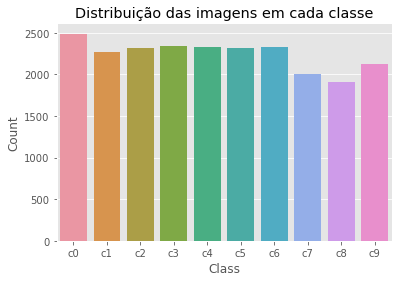

In [9]:
sns.barplot(x='Class', y='Count', data=pd.DataFrame.from_dict(
    {dir: [len(glob.glob(os.path.join(train_data_dir, dir, '*.jpg')))] for dir in os.listdir(train_data_dir)}, 
    orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Class'})).set_title('Distribuição das imagens em cada classe');

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [10]:
# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError: # If TPU not found
    tpu = None
    
# Select appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
    strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
    if len(tf.config.experimental.list_physical_devices('GPU')) or len(tf.config.experimental.list_physical_devices('XLA_GPU')):
        print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')) + len(tf.config.experimental.list_physical_devices('XLA_GPU')))
    else:
        print('Running on CPU instead')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Num GPUs Available:  1
Number of accelerators:  1


In [11]:
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*')])
CLASS_NAMES

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
      dtype='<U2')

In [12]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
train_valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [13]:
BATCH_SIZE = 128
if tpu:
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_SIZE = 160
IMG_HEIGHT = 160
IMG_WIDTH = 160
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)

In [14]:
BATCH_SIZE

128

In [15]:
train_data_gen = train_valid_generator.flow_from_directory(directory=str(train_data_dir),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 classes = list(CLASS_NAMES),
                                                 subset='training')
validation_data_gen = train_valid_generator.flow_from_directory(directory=str(train_data_dir),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 classes = list(CLASS_NAMES),
                                                 subset='validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [16]:
test_data_gen = test_generator.flow_from_directory(directory=str(data_dir), classes=['test'], class_mode=None, shuffle=False, target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 79726 images belonging to 1 classes.


In [17]:
def show_batch(image_batch, label_batch=None,predict_labels=None):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        
        if predict_labels is not None:
            true_class =  CLASS_NAMES[label_batch[n]==1][0].title() if label_batch is not None else '?'
            predicted_class = CLASS_NAMES[predict_labels[n]].title()
            color = 'green' if true_class == predicted_class else 'red'
            plt.title(f'P: {predicted_class} - R: {true_class}', fontdict={'color': color if label_batch is not None else 'black'})
        elif label_batch is not None:
            plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

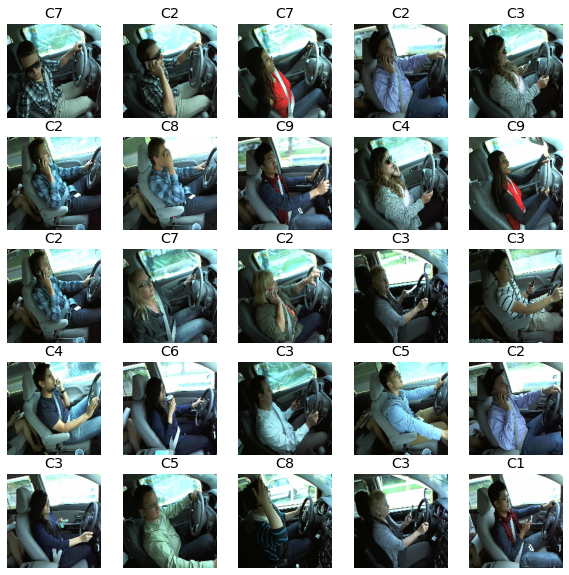

In [18]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [19]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def create_model(train_base_model=False):
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = train_base_model
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.Sequential([
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ]) 
    
    model = tf.keras.Sequential([
      base_model,
      global_average_layer,
      prediction_layer
    ])
    
    return model

In [20]:
with strategy.scope():
    train_ds = train_data_gen
    valid_ds = validation_data_gen
    test_ds = test_data_gen
    if tpu:
        train_ds = tf.data.TFRecordDataset.from_generator(lambda: train_data_gen, output_types=(tf.float32, tf.float32), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3], [BATCH_SIZE, len(CLASS_NAMES)]))
        valid_ds = tf.data.TFRecordDataset.from_generator(lambda: validation_data_gen, output_types=(tf.float32, tf.float32), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3], [BATCH_SIZE, len(CLASS_NAMES)]))
        test_ds = tf.data.TFRecordDataset.from_generator(lambda: test_data_gen, output_types=(tf.float32, ), output_shapes=([BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3],))
        
    
    model = create_model()
    base_learning_rate = 0.001
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

9412608/9406464 [==============================] - 1s 0us/step


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
sequential (Sequential)      (None, 10)                362122    
Total params: 2,620,106
Trainable params: 362,122
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
len(model.trainable_variables)

6

In [23]:
validation_steps=20
loss0,accuracy0 = model.evaluate(valid_ds, steps = validation_steps)

20/20 [==============================] - 69s 3s/step - loss: 2.3071 - accuracy: 0.1039


In [24]:
epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds)

Epoch 1/20
     13/Unknown - 56s 4s/step - loss: 2.3245 - accuracy: 0.1034

KeyboardInterrupt: 

In [0]:
epochs = 20
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
history = model.fit(train_ds, epochs=initial_epochs, validation_data=valid_ds)

Train for 141 steps, validate for 36 steps
Epoch 1/50
141/141 [==============================] - 125s 887ms/step - loss: 1.5881 - accuracy: 0.8727 - val_loss: 2.1991 - val_accuracy: 0.2386
Epoch 2/50
141/141 [==============================] - 122s 868ms/step - loss: 1.5782 - accuracy: 0.8840 - val_loss: 2.2023 - val_accuracy: 0.2341
Epoch 3/50
141/141 [==============================] - 122s 867ms/step - loss: 1.5765 - accuracy: 0.8850 - val_loss: 2.2138 - val_accuracy: 0.2238
Epoch 4/50
141/141 [==============================] - 122s 866ms/step - loss: 1.5769 - accuracy: 0.8849 - val_loss: 2.2058 - val_accuracy: 0.2345
Epoch 5/50
141/141 [==============================] - 121s 860ms/step - loss: 1.5755 - accuracy: 0.8849 - val_loss: 2.2121 - val_accuracy: 0.2332
Epoch 6/50
141/141 [==============================] - 122s 866ms/step - loss: 1.5756 - accuracy: 0.8855 - val_loss: 2.2221 - val_accuracy: 0.2292
Epoch 7/50
141/141 [==============================] - 121s 860ms/step - loss: 1.5

In [0]:
epochs = 20

model.layers[0].trainable = True
history = model.fit(train_ds, epochs=initial_epochs, validation_data=valid_ds)

Train for 141 steps, validate for 36 steps
Epoch 1/50
141/141 [==============================] - 122s 868ms/step - loss: 1.5685 - accuracy: 0.8919 - val_loss: 2.1973 - val_accuracy: 0.2392
Epoch 2/50
141/141 [==============================] - 122s 864ms/step - loss: 1.5649 - accuracy: 0.8972 - val_loss: 2.1990 - val_accuracy: 0.2401
Epoch 3/50
141/141 [==============================] - 122s 863ms/step - loss: 1.5648 - accuracy: 0.8971 - val_loss: 2.1968 - val_accuracy: 0.2408
Epoch 4/50
141/141 [==============================] - 123s 870ms/step - loss: 1.5645 - accuracy: 0.8966 - val_loss: 2.2029 - val_accuracy: 0.2352
Epoch 5/50
141/141 [==============================] - 122s 862ms/step - loss: 1.5666 - accuracy: 0.8956 - val_loss: 2.2041 - val_accuracy: 0.2325
Epoch 6/50
141/141 [==============================] - 122s 862ms/step - loss: 1.5635 - accuracy: 0.8976 - val_loss: 2.1960 - val_accuracy: 0.2412
Epoch 7/50
141/141 [==============================] - 123s 875ms/step - loss: 1.5

In [0]:
loss1, accuracy1 = model.evaluate(valid_ds, steps = validation_steps)

20/20 [==============================] - 15s 758ms/step - loss: 2.2224 - accuracy: 0.2316


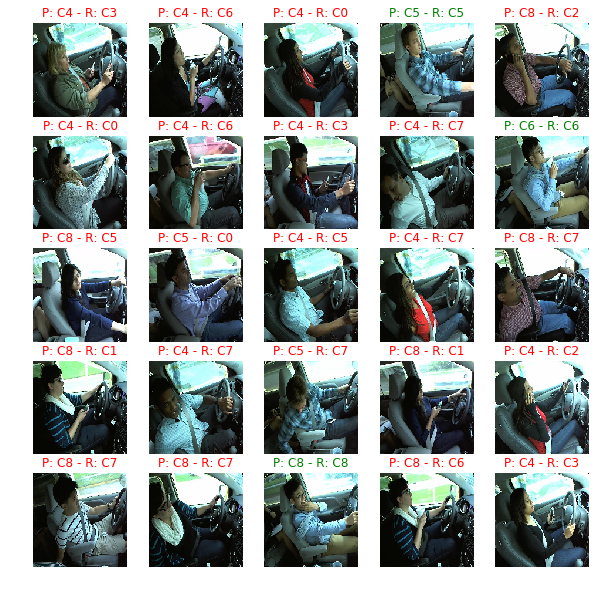

In [0]:
image_batch, label_batch = next(valid_ds)
predicted_labels = model.predict_classes(image_batch)
show_batch(image_batch, label_batch, predicted_labels)

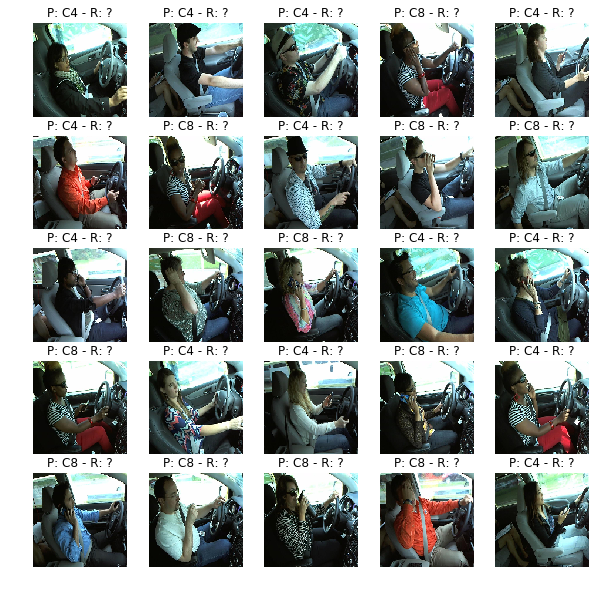

In [0]:
image_batch = next(test_ds)
predicted_labels = model.predict_classes(image_batch)
show_batch(image_batch, predict_labels=predicted_labels)

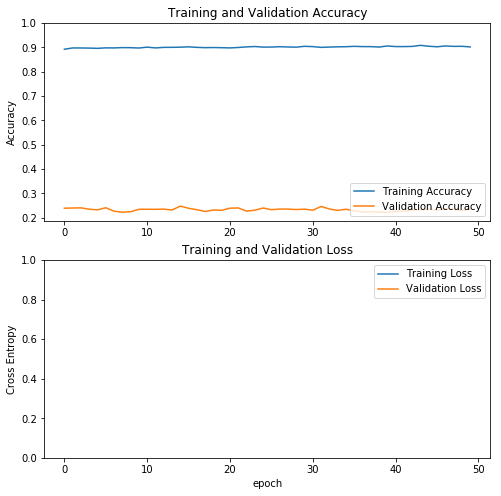

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
loss1,accuracy1 = model.evaluate(validation_data_gen, steps = validation_steps)

20/20 [==============================] - 15s 739ms/step - loss: 2.2201 - accuracy: 0.2363


In [0]:
len(model.trainable_variables)

162

In [0]:
pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv')

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [0]:
list_ds = tf.data.Dataset.list_files('/kaggle/input/state-farm-distracted-driver-detection/imgs/train/*/*')

for f in list_ds.take(5):
    print(f.numpy())

b'/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c9/img_25689.jpg'
b'/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c8/img_12025.jpg'
b'/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c2/img_60427.jpg'
b'/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c1/img_51487.jpg'
b'/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c8/img_19078.jpg'


In [0]:
from glob import glob
glob("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/*/")

['/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c4/',
 '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c0/',
 '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c1/',
 '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c7/',
 '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c3/',
 '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c2/',
 '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/',
 '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c6/',
 '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c8/',
 '/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c9/']

In [0]:
list(os.walk('/kaggle/input/state-farm-distracted-driver-detection/imgs/train/*/'))

[]

In [0]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('/kaggle/input/state-farm-distracted-driver-detection/imgs/train/*')])
CLASS_NAMES

AttributeError: 'str' object has no attribute 'glob'

In [0]:
def process_path(file_path):
    label = tf.strings.split(file_path, '/')[-2]
    return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [0]:
for image_raw, label_text in labeled_ds.take(5):
    print(repr(image_raw.numpy()[:20]), label_text.numpy())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00' b'c2'
b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00' b'c1'
b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00' b'c2'
b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00' b'c1'
b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00' b'c4'


In [0]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')


In [0]:
labeled_ds

<MapDataset shapes: ((), ()), types: (tf.string, tf.string)>